In [1]:
import os
from utils import f1_score_function
from BertClassifier import BertClassifier, init_bert_clf, train_bert_clf, eval_bert_clf
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-08 01:52:20.977594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Analyze dataset

In [2]:
texts_df = pd.read_csv('subtaskA_train.csv')

In [3]:
texts_df.head()

,comment_text,conspiratorial
0,⚡Se non ci fossero soldati non ci sarebbero gu...,0
1,"21/08/21]( [PRE-PRINT]\n\n📄__ ""Shedding of Inf...",1
2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,L'Italia non puo' dare armi lo vieta la Costit...,0


In [4]:
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1845 entries, 0 to 1844
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   comment_text    1842 non-null   object
 1   conspiratorial  1845 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 29.0+ KB


In [5]:
texts_df[texts_df['comment_text'].isna()]

,comment_text,conspiratorial
244,NaN,0
263,NaN,0
665,NaN,0


In [6]:
texts_df = texts_df[texts_df.comment_text.notna()]

In [7]:
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1842 entries, 0 to 1844
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   comment_text    1842 non-null   object
 1   conspiratorial  1842 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.2+ KB


In [8]:
texts_df.conspiratorial.value_counts()

1    925
0    917
Name: conspiratorial, dtype: int64

## Preprocessing

Remove break line characthers

In [9]:
texts_df.comment_text = texts_df.comment_text.apply(lambda text: text.replace('\n\n', ' ').replace('\n', ' '))

## Train-Validation split

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

80-20 train-validation split

In [11]:
# Split the data into training and testing datasets using stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, eval_index in split.split(texts_df, texts_df.conspiratorial):
    train_df, val_df = texts_df.iloc[train_index], texts_df.iloc[eval_index]

In [12]:
print(train_df.info())
print(train_df.conspiratorial.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1473 entries, 1512 to 1771
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   comment_text    1473 non-null   object
 1   conspiratorial  1473 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.5+ KB
None
1    740
0    733
Name: conspiratorial, dtype: int64


In [13]:
print(val_df.info())
print(val_df.conspiratorial.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 363 to 670
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   comment_text    369 non-null    object
 1   conspiratorial  369 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.6+ KB
None
1    185
0    184
Name: conspiratorial, dtype: int64


## Tokenization

In [14]:
from transformers import BertTokenizer

In [15]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-italian-xxl-cased', do_lower_case=False)

texts_tr = train_df['comment_text']
labels_tr = train_df['conspiratorial'].to_numpy()

In [16]:
texts_tr = train_df['comment_text']
labels_tr = train_df['conspiratorial'].to_numpy()

texts_val = val_df['comment_text']
labels_val = val_df['conspiratorial'].to_numpy()

Observe distribution of tokenized texts lengths by trying a simple tokenization on both tr and val sets.

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


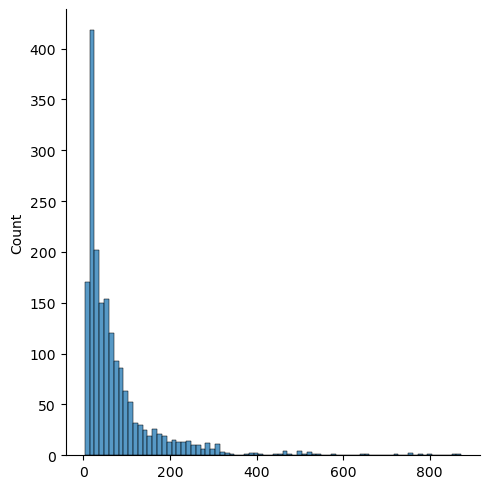

In [17]:
tokenized_len_list = []

for sentence in texts_tr:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))
for sentence in texts_val:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))

sns.displot(tokenized_len_list)
plt.show()

The maximum tokenized length is above the BERT max_lenght limit of 512. Very few texts are above this limit, so we truncate to 512

In [18]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

# Tr set
input_ids_tr = []
attention_masks_tr = []

# `encode_plus` will:
#   1. Tokenize the sentence, 2. Prepend the `[CLS]` token to the start, 3. Append the `[SEP]` token to the end
#   4. Map tokens to their IDs, 5. Pad or truncate the sentence to `max_length`, 6. Create attention masks for [PAD] tokens

for sentence in texts_tr:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_tr.append(encoded_dict['input_ids'])
    attention_masks_tr.append(encoded_dict['attention_mask'])

# Val set
input_ids_val = []
attention_masks_val = []

for sentence in texts_val:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_val.append(encoded_dict['input_ids'])
    attention_masks_val.append(encoded_dict['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
# Convert the lists into tensors

input_ids_tr = torch.cat(input_ids_tr, dim=0)
input_ids_val = torch.cat(input_ids_val, dim=0)

attention_masks_tr = torch.cat(attention_masks_tr, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)

labels_tr = torch.tensor(labels_tr)
labels_val = torch.tensor(labels_val)

## Generate DataLoaders

In [20]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

Wrap data into a TensorDataset

In [21]:
tr_dataset = TensorDataset(input_ids_tr, attention_masks_tr, labels_tr)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)

The DataLoader needs to know our batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

In [22]:
batch_size = 16

Create the DataLoaders for our training and validation sets. Tr samples are taken in random order, while validation are taken sequentially.

In [23]:
tr_dataloader = DataLoader(tr_dataset, sampler=RandomSampler(tr_dataset), batch_size = batch_size)

val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size = batch_size)

## Training Grid Search

In [24]:
print(torch.cuda.memory_summary())

/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


KeyError: 'allocated_bytes.all.current'

Set save folder for this run

In [ ]:
from datetime import datetime
curr_date = datetime.now()

print(datetime.now())

save_folder_pth = './bert_subtaskA/{}_{}_{}-{}.{}'.format(curr_date.day, curr_date.month, curr_date.day, curr_date.hour, curr_date.minute)
if(not os.path.exists(save_folder_pth)):
    os.makedirs(save_folder_pth)

2023-04-08 01:51:08.420811


Fixed general hyperparams

In [ ]:
max_epochs = 15


# Num batches*num epochs
tr_steps = len(tr_dataloader)*max_epochs

Variable grid searched hyperparams

In [ ]:
lr_list = [0.5e-5, 0.2e-5, 0.8e-5]
warmup_perc_list = [0.1, 0.05] # Percentage of warmup steps for scheduler on the total tr steps
clf_head_list = []

head1 = nn.Sequential(
                nn.Linear(768, 128),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(128, 2),
                )
clf_head_list.append((head1, '2_layers_S')) # Each head obeject is composed by a tuple (head, name)

head2 = nn.Sequential(
                nn.Linear(768, 256),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(256, 2),
                )
clf_head_list.append((head2, '2_layers_M'))

head3 = nn.Sequential(
                nn.Linear(768, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 32),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(32, 2),
                )
clf_head_list.append((head3, '3_layers_M'))

Initialize, train/eval and save function for each grid search run

In [ ]:
def train_eval_model(lr, warmup_steps, head, model_folder_pth):

    torch.cuda.empty_cache()
    #print(torch.cuda.memory_summary())

    # Initialize model
    bert_clf_model, loss_function, optimizer, scheduler, device = init_bert_clf(tr_steps=tr_steps, lr_rate=lr, scheduler_warmp_steps=warmup_steps, head=head)

    for epoch_i in range(max_epochs):
        print('Epoch: {}'.format(epoch_i))

        # Train
        avg_epoch_loss_tr, acc_score_tr, f1_score_tr, bert_clf_model, optimizer, scheduler = train_bert_clf(bert_clf_model, tr_dataloader, loss_function, optimizer, scheduler, device)


        print('TRAINING | Tr Loss: {} - Tr acc: {} - Tr f1: {}'.format(avg_epoch_loss_tr, acc_score_tr, f1_score_tr))

        # Eval
        avg_epoch_loss_val, acc_score_val, f1_score_val, predictions, labels = eval_bert_clf(bert_clf_model, val_dataloader, loss_function, device)
        print('EVALUATION | Val Loss: {} - Val acc: {} - Val f1: {}'.format(avg_epoch_loss_val, acc_score_val, f1_score_val))

        # Save
        model_save_pth = os.path.join(model_folder_pth, 'bert_clf.pt')
        torch.save({
                    'epoch': epoch_i,
                    'model_state_dict': bert_clf_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'schdeduler_state_dict': scheduler.state_dict(),
                    'tr_loss': avg_epoch_loss_tr,
                    'val_loss': avg_epoch_loss_val,
                    'tr_acc': acc_score_tr,
                    'val_acc': acc_score_val,
                    'tr_f1': f1_score_tr,
                    'val_f1': f1_score_val,
                    'val_preds': predictions
                    }, model_save_pth)

    torch.cuda.empty_cache()


Grid Search loop

In [ ]:
num_trials = len(lr_list) * len(warmup_perc_list) * len(clf_head_list)
print('Executing {} trials in grid search'.format(num_trials))


for lr in lr_list:
    for clf_head_tuple in clf_head_list:
        for warmup_perc in warmup_perc_list:
            
            # Model save path subfolder
            model_folder_str = 'lr{}_warmup{}_head_{}'.format(lr, warmup_perc, clf_head_tuple[1])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)

            print('Executing model with lr={}, warmup perc.={}, head={}'.format(lr, warmup_perc, clf_head_tuple[1]))

            train_eval_model(lr, warmup_steps=warmup_perc*tr_steps, head=clf_head_tuple[0], model_folder_pth=model_folder_pth)

           

Executing 18 trials in grid search
Executing model with lr=5e-06, warmup perc.=0.1, head=2_layers_S


Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

No GPU available, using the CPU instead.
Epoch: 0


KeyboardInterrupt: 

## Initialize model

In [ ]:
lr_rate = 0.5e-5
scheduler_warmup_step = 0
max_epochs = 12

# Num batches*num epochs
tr_steps = len(tr_dataloader)*max_epochs

In [ ]:
bert_clf_model, loss_function, optimizer, scheduler, device = init_bert_clf(tr_steps=tr_steps, lr_rate=lr_rate, scheduler_warmp_steps=scheduler_warmup_step)

Some weights of the model checkpoint at m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [ ]:
print('Using as device:', device)

Using as device: cuda


In [ ]:
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

## Training

In [ ]:
from datetime import datetime
curr_date = datetime.now()

print(datetime.now())

save_folder_pth = './bert_subtaskA/{}_{}_{}-{}.{}'.format(curr_date.day, curr_date.month, curr_date.day, curr_date.hour, curr_date.minute)
if(not os.path.exists(save_folder_pth)):
    os.makedirs(save_folder_pth)

2023-04-07 20:54:26.856705


In [ ]:
curr_optimizer = optimizer
curr_scheduler = scheduler
curr_bert_clf = bert_clf_model

In [ ]:
for epoch_i in range(max_epochs):
    # Train
    avg_epoch_loss_tr, acc_score_tr, f1_score_tr, model, optimizer, scheduler = train_bert_clf(bert_clf_model, tr_dataloader, loss_function, optimizer, scheduler, device)
    curr_optimizer = optimizer
    curr_scheduler = scheduler
    curr_bert_clf = model
    
    print('Epoch: {}| Tr Loss: {} - Tr acc: {} - Tr f1: {}'.format(epoch_i, avg_epoch_loss_tr, acc_score_tr, f1_score_tr))

    # Eval
    avg_epoch_loss_val, acc_score_val, f1_score_val, predictions, labels = eval_bert_clf(bert_clf_model, val_dataloader, loss_function, device)
    print('EVALUATION | Val Loss: {} - Val acc: {} - Val f1: {}'.format(avg_epoch_loss_val, acc_score_val, f1_score_val))

    # Save
    save_path = os.path.join(save_folder_pth, 'bert_clf.pt')
    torch.save({
                'epoch': epoch_i,
                'model_state_dict': curr_bert_clf.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'schdeduler_state_dict': scheduler.state_dict(),
                'tr_loss': avg_epoch_loss_tr,
                'val_loss': avg_epoch_loss_val,
                'tr_acc': acc_score_tr,
                'val_acc': acc_score_val,
                'tr_f1': f1_score_tr,
                'val_f1': f1_score_val,
                'val_preds': predictions
                }, save_path)

Epoch: 0| Tr Loss: 0.5996617819032362 - Tr acc: 0.6822810590631364 - Tr f1: 0.6821402750317231
EVALUATION | Val Loss: 0.5791960420707861 - Val acc: 0.7073170731707317 - Val f1: 0.706175533797334
Epoch: 1| Tr Loss: 0.5012985153864788 - Tr acc: 0.7522063815342838 - Tr f1: 0.7515096053188024
EVALUATION | Val Loss: 0.5726963058114052 - Val acc: 0.7100271002710027 - Val f1: 0.7099930221455066
Epoch: 2| Tr Loss: 0.38508068097214543 - Tr acc: 0.8268839103869654 - Tr f1: 0.8267149163619152
EVALUATION | Val Loss: 0.676938553651174 - Val acc: 0.7046070460704607 - Val f1: 0.7046070460704607
Epoch: 3| Tr Loss: 0.2432950676609111 - Tr acc: 0.9056347589952478 - Tr f1: 0.9055504838330966
EVALUATION | Val Loss: 0.7926696756233772 - Val acc: 0.6802168021680217 - Val f1: 0.6793667157584684
Epoch: 4| Tr Loss: 0.15581155434170718 - Tr acc: 0.9484046164290564 - Tr f1: 0.9483941274740836
EVALUATION | Val Loss: 1.0593588165938854 - Val acc: 0.6937669376693767 - Val f1: 0.6937579412002322
Epoch: 5| Tr Loss: 0